### Importing libraries


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.animation as animation
from IPython.display import Image as imgdis

## 1) Variants of Backprop for visualizing CNNs

### Loading ResNet50 model

In [2]:
model = models.resnet50(weights='ResNet50_Weights.DEFAULT')

### Loading images and stroing them in list

In [3]:
Images = []

for i in range(5):
    Images.append(Image.open(f'ilsvrc2012-sample-images/i{i+1}.jpg'))

### Images without transformation

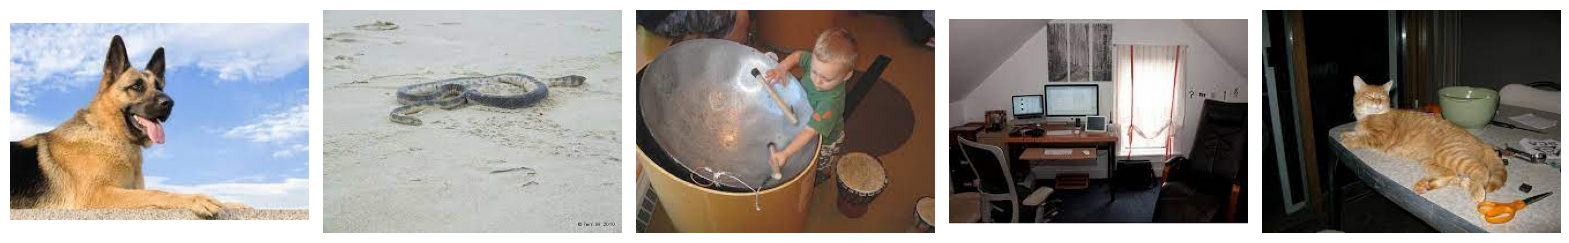

In [4]:
fig, axs = plt.subplots(nrows=1, ncols=5, gridspec_kw={'wspace':0.05, 'hspace':0},squeeze=True,figsize=(20,8))

for i, image in enumerate(Images):
    axs[i].axis("off")
    axs[i].imshow(image)

### Transforming images using transform funciton

In [5]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [6]:
transformImages = []
for img in Images:
    img = transform(img)
    img = img.unsqueeze(0)
    img.requires_grad = True
    transformImages.append(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


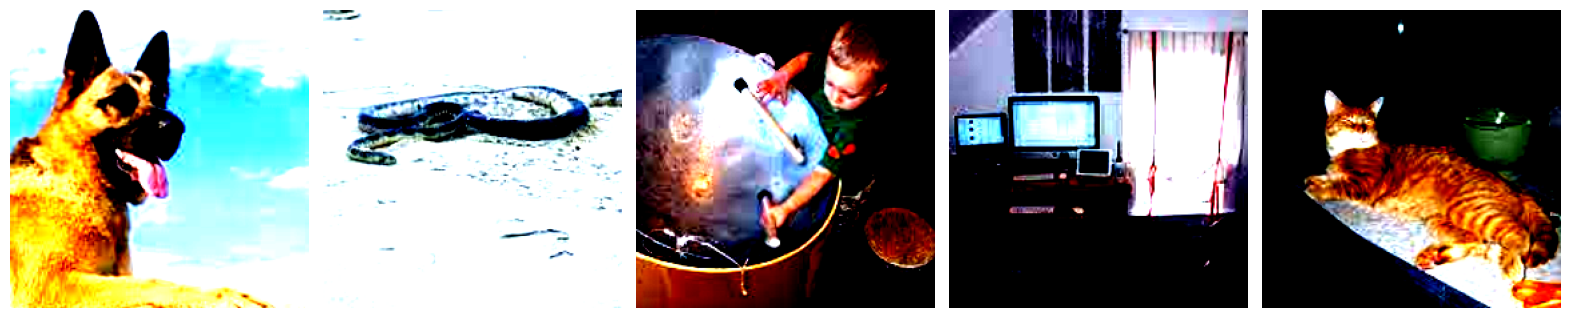

In [7]:
fig, axs = plt.subplots(nrows=1, ncols=5, gridspec_kw={'wspace':0.05, 'hspace':0},squeeze=True,figsize=(20,8))

for i, image in enumerate(transformImages):
    axs[i].axis("off")
    axs[i].imshow(image.squeeze().permute(1,2,0).detach())

### Making evaluation  of image and getting maxscore index

In [8]:
outputs = []
maxIndices = []

for img in transformImages:
    outputs.append(model(img))

for i,modelimg in enumerate(outputs):
    scores = torch.nn.functional.softmax(modelimg, dim=1)[0]
    maxIndex = torch.argmax(scores)
    maxIndices.append(maxIndex)
    print(outputs[i][0][maxIndex])

tensor(1.2119, grad_fn=<SelectBackward0>)
tensor(0.7689, grad_fn=<SelectBackward0>)
tensor(1.0980, grad_fn=<SelectBackward0>)
tensor(1.0574, grad_fn=<SelectBackward0>)
tensor(1.1102, grad_fn=<SelectBackward0>)


### a) Vanilla Backpropagation

In [9]:
vanilla_backprop = []
for i,idx in enumerate(maxIndices):
    one_hot = torch.zeros((1, outputs[i].size()[-1]), dtype=torch.float32)
    one_hot[0][idx] = 1.0
    outputs[i].clone().backward(gradient=one_hot, retain_graph=True)
    grad = transformImages[i].grad.data.numpy()[0]
    grad = (grad - np.min(grad)) / (np.max(grad) - np.min(grad) + 1e-8)
    vanilla_backprop.append(grad.transpose(1, 2, 0))

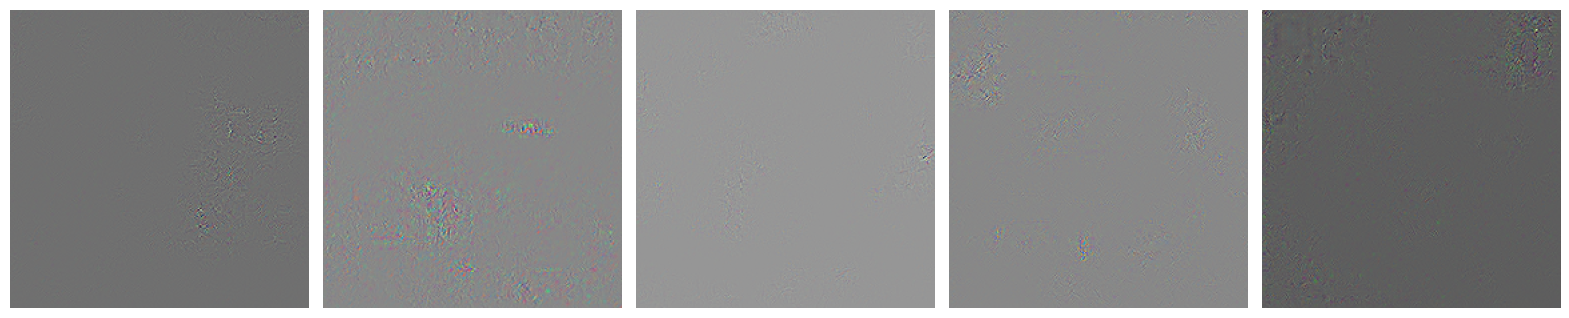

In [10]:
fig, axs = plt.subplots(nrows=1, ncols=5, gridspec_kw={'wspace':0.05, 'hspace':0},squeeze=True,figsize=(20,8))

for i, image in enumerate(vanilla_backprop):
    axs[i].axis("off")
    axs[i].imshow(image)

### b) Guided-back-propagation

In [11]:
def guided_backpropagation(model, input_image, target_class):
    # Set the model to evaluation mode
    model.eval()

    # Enable hooks for ReLU layers
    hooks = []
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.ReLU):
            hook = module.register_backward_hook(lambda module, grad_input, grad_output: (F.relu(grad_input[0]),))
            hooks.append(hook)

    # Forward propagate the input image
    output = model(input_image)

    grad_target = torch.zeros(output.shape)
    grad_target[0][target_class] = 1

    # Backward propagate the gradients from the output layer to the input layer
    model.zero_grad()
    output.backward(gradient=grad_target, retain_graph=True)

    # Compute the guided backpropagation gradients
    guided_gradients = input_image.grad.data.cpu().numpy()[0]

    # Remove the hooks
    for hook in hooks:
        hook.remove()

    # Return the guided backpropagation gradients
    return guided_gradients


In [12]:
for _ in range(5):
    guided_back_prop = []
    for i,idx in enumerate(maxIndices):
        guided_grads = guided_backpropagation(model, transformImages[i], idx)
        guided_grads = guided_grads-np.min(guided_grads)
        guided_grads /= np.max(guided_grads)
        guided_back_prop.append(guided_grads.transpose(1,2,0))

/home/bhanu/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1113: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


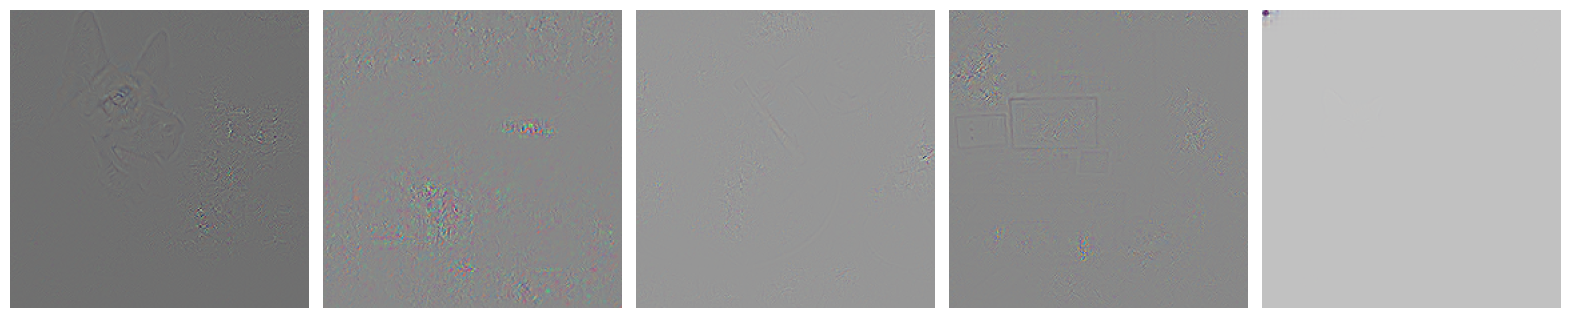

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=5, gridspec_kw={'wspace':0.05, 'hspace':0},squeeze=True,figsize=(20,8))

for i, image in enumerate(guided_back_prop):
    axs[i].axis("off")
    axs[i].imshow(image)

### c) Class Activatoin Map (CAM)

In [14]:
class_activation_map = []
for i,idx in enumerate(class_activation_map):
    pass

### d) Guided Grad-CAM

In [15]:
guided_cam = []
for i,idx in enumerate(maxIndices):
    pass

## 2) SGD Update rule variations


#### defining function and gradient

In [16]:
f = lambda x,y : 10 * x**2 + y**2
grad_f = lambda x,y: np.array([20*x, 2*y])

#### defining learning rate, no.of iterations and initial points

In [17]:
lr = 0.01
n_iter = 50
x_init, y_init = np.random.uniform(low=13, high=17, size=2)

#### a) Vanilla SGD

In [18]:
x_vsgd, y_vsgd = x_init, y_init
path_vsgd = [(x_vsgd, y_vsgd)]

for i in range(n_iter):
    x_vsgd -= lr * grad_f(x_vsgd, y_vsgd)[0]
    y_vsgd -= lr * grad_f(x_vsgd, y_vsgd)[1]
    path_vsgd.append((x_vsgd, y_vsgd))

#### b) SGD with momentum

In [19]:
x_sgd_momentum, y_sgd_momentum = x_init, y_init
v_sgd_momentum = np.array([0, 0])
path_sgd_momentum = [(x_sgd_momentum, y_sgd_momentum)]

for i in range(n_iter):
    v_sgd_momentum = 0.9 * v_sgd_momentum - lr * grad_f(x_sgd_momentum, y_sgd_momentum)
    x_sgd_momentum += v_sgd_momentum[0]
    y_sgd_momentum += v_sgd_momentum[1]
    path_sgd_momentum.append((x_sgd_momentum, y_sgd_momentum))

#### c) Nesterov Momentum

In [20]:
x_nesterov, y_nesterov = x_init, y_init
v_nesterov = np.array([0, 0])
path_nesterov = [(x_nesterov, y_nesterov)]

for i in range(n_iter):
    v_nesterov = 0.9 * v_nesterov - lr * grad_f(x_nesterov + 0.9 * v_nesterov[0], y_nesterov + 0.9 * v_nesterov[1])
    x_nesterov += v_nesterov[0]
    y_nesterov += v_nesterov[1]
    path_nesterov.append((x_nesterov, y_nesterov))

####  d) AdaGrad

In [21]:
lr = 0.25
x_adagrad, y_adagrad = x_init, y_init
h_adagrad = np.array([0, 0])
path_adagrad = [(x_adagrad, y_adagrad)]

for i in range(n_iter):
    grad = grad_f(x_adagrad,y_adagrad)
    h_adagrad = h_adagrad + grad**2
    x_adagrad -= (lr/ np.sqrt(h_adagrad[0] + 1e-8)) * grad[0]
    y_adagrad -= (lr/ np.sqrt(h_adagrad[1] + 1e-8)) * grad[1] 
    path_adagrad.append((x_adagrad,y_adagrad))

#### e) RMSProp

In [22]:
x_rmsprop, y_rmsprop = x_init, y_init
h_rmsprop = np.array([0, 0])
path_rmsprop = [(x_rmsprop, y_rmsprop)]

for i in range(n_iter):
    grad = grad_f(x_adagrad,y_adagrad)
    h_rmsprop = 0.9 * h_rmsprop + 0.1 * grad**2
    x_rmsprop -= lr * grad[0] / (np.sqrt(h_rmsprop[0]) + 1e-3)
    y_rmsprop -= lr * grad[1] / (np.sqrt(h_rmsprop[1]) + 1e-3)
    path_rmsprop.append((x_rmsprop, y_rmsprop))

#### Visualizing the convergence

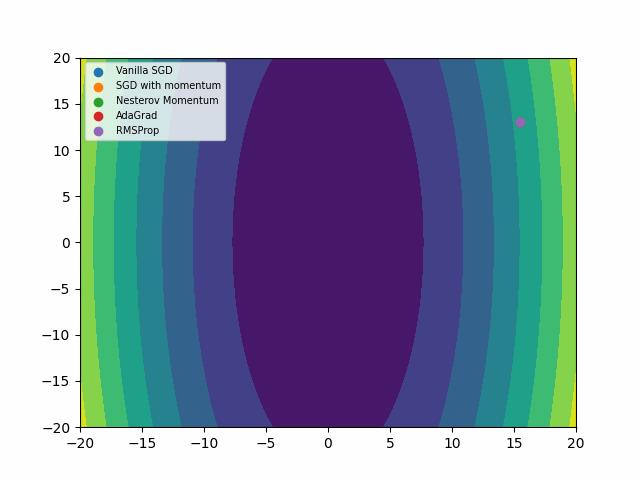

In [23]:
fig, ax = plt.subplots()
x = np.linspace(-20, 20, 100)
y = np.linspace(-20, 20, 100)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

def update(frame):
    x1, y1 = zip(*path_vsgd[:frame+1])
    x2, y2 = zip(*path_sgd_momentum[:frame+1])
    x3, y3 = zip(*path_nesterov[:frame+1])
    x4, y4 = zip(*path_adagrad[:frame+1])
    x5, y5 = zip(*path_rmsprop[:frame+1])
    ax.clear()
    ax.contourf(X, Y, Z)
    ax.scatter(x1, y1, label='Vanilla SGD')
    ax.scatter(x2, y2, label='SGD with momentum')
    ax.scatter(x3, y3, label='Nesterov Momentum')
    ax.scatter(x4, y4, label='AdaGrad')
    ax.scatter(x5, y5, label='RMSProp')
    ax.set_xlim(-20,20)
    ax.set_ylim(-20,20)
    ax.legend(fontsize=7, loc='upper left', ncol=1)

ani = animation.FuncAnimation(fig, update, frames=50, interval=200)
ani.save('animation.gif', writer='pillow')

plt.close()

imgdis(open('animation.gif','rb').read())